# Life Expectancy (WHO) Machine Learning

We will examine the `Life Expectancy` within the health status dataset collected by the WHO in the year 2015 using **Support Vector Regression**.

In [139]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import plotly.express as px
from plotly.offline import init_notebook_mode
import warnings

#Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

#Preproccessing & model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#SVR
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlxtend.evaluate import bias_variance_decomp

color_pal = sns.color_palette(palette="muted")
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")


In [140]:
#import data
life = pd.read_csv("Life Expectancy Data.csv")

In [141]:
life

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [142]:
life.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

There are 2938 entries with total 22 columns. 21 columns are features and the column **Life expectancy** will be handled as target columns

**Country** and **Status** are two categorical features. While for **Country** it is clear that we have several unique outcomes, let's check whether we can transform **Status** to a numerical variable

In [143]:
life.Status.value_counts()

Developing    2426
Developed      512
Name: Status, dtype: int64

For **Status** there are two outcomes:
1. Developing
2. Developed

While we can transform Status easily, using the `.replace` function from pandas, we just drop the country column.


In [144]:
#replacing developing and developed with 0 and 1 for further analysis
life["Status"].replace(["Developing", "Developed"], [0,1], inplace=True)
#drop country
life = life.drop(columns="Country", axis=1, inplace=False)

For now, we have just dropped all NA's to visualize Life expectancy by Country and Status. But for further analysis we will test some Imputation-methods. Let's check for missing values.

In [145]:
life.isna().sum()

Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

There are 14 features with null values. Some have a lot of null values, such as population with 652 null values and Hepatitis B with 553 null values. We will later see, that especially population as a feature do not have any effects on life expectancy. This makes sense because the amount of population does not say anything about how long we would live as an individual.

We will use several techniques:
## IterativeImputer
The IterativImputer from sklearn is a machine learning tool for imputing missing values in datasets. The IterativeImputer works by modeling each feature with missing values as a function of other features in a round-robin fashion. In each round, the missing values of one feature are imputed using the observed values of the other features. The process is repeated for each feature multiple times until the missing values have been filled in. The algorithm uses the Bayesian Ridge regression model as its default imputation method, but other models can be specified as well.

## KNNImputer
It uses the k-nearest neighbors to impute missing values. In difference to simpler form like filling NA's with a fixed value or the mean of the column, the KKNImputer provides a more accurate estimation of missing values. While the `Iterative Imputer` is likely to consider complex dependencies within a dataframe, the `KNNImputer` may be more appropriate for datasets where similar samples are likely to have similar missing values

## SimpleImputer
Lastly, the SimpleImputer is an easy and quick method to fill NA's with a fix value or with e.g. the mean or median of each feature.

In general, for more complex datasets (e.g. with non-linear relationsships between features), more advanced imputation methods like `IterativeImputer` or `KNNImputer` may be more effectiv.

In [146]:
imp_iter = IterativeImputer(max_iter=10, random_state=0)
imputed_iter = imp_iter.fit_transform(life)
life_imp_iter = pd.DataFrame(imputed_iter, columns=life.columns)

imp_knn = KNNImputer(n_neighbors=3)
imputed_knn = imp_knn.fit_transform(life)
life_imp_knn = pd.DataFrame(imputed_knn, columns=life.columns)

imp_mean = SimpleImputer(strategy="mean")
imputed_mean = imp_mean.fit_transform(life)
life_imp_mean = pd.DataFrame(imputed_mean, columns=life.columns)

imp_median = SimpleImputer(strategy="median")
imputed_median = imp_median.fit_transform(life)
life_imp_median = pd.DataFrame(imputed_median, columns=life.columns)



In [147]:
null_features = ['Life expectancy ', 'Adult Mortality', 'Alcohol', 'Hepatitis B', ' BMI ', 'Polio',
       'Total expenditure', 'Diphtheria ', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling']

In [148]:
def draw_histplot():
    f, axes = plt.subplots(nrows=len(null_features), ncols=5, figsize=(24, len(null_features)*6))
    for x in range(0, len(null_features)):
        sns.histplot(life, x=null_features[x], kde=True, ax=axes[x, 0], color=color_pal[0])
        sns.histplot(life_imp_iter, x=null_features[x], kde=True, ax=axes[x, 1], color=color_pal[1])
        sns.histplot(life_imp_knn, x=null_features[x], kde=True, ax=axes[x, 2], color=color_pal[2])
        sns.histplot(life_imp_mean, x=null_features[x], kde=True, ax=axes[x, 3], color=color_pal[3])
        sns.histplot(life_imp_median, x=null_features[x], kde=True, ax=axes[x, 4], color=color_pal[4])
    for i, ax in enumerate(axes.reshape(-1)):
        if i % 5 == 0:
            selected_title = 'Before Imputation'
            selected_data = life[null_features[int(i/5)]].dropna()
            ax.set_title(selected_title)
        elif i % 5 == 1:
            selected_title = 'Iterative Imputation'
            selected_data = life_imp_iter[null_features[int(i/5)]]
            ax.set_title(selected_title)
        elif i % 5 == 2:
            selected_title = 'KNN Imputation'
            selected_data = life_imp_knn[null_features[int(i/5)]]
            ax.set_title(selected_title)
        elif i % 5 == 3:
            selected_title = 'Mean Imputation'
            selected_data = life_imp_mean[null_features[int(i/5)]]
            ax.set_title(selected_title)
        elif i % 5 == 4:
            selected_title = 'Median Imputation'
            selected_data = life_imp_median[null_features[int(i/5)]]
            ax.set_title(selected_title)
        ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % skew(selected_data),
            fontsize=9, verticalalignment='top', horizontalalignment='right')
        ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % kurtosis(selected_data),
            fontsize=9, verticalalignment='top', horizontalalignment='right')

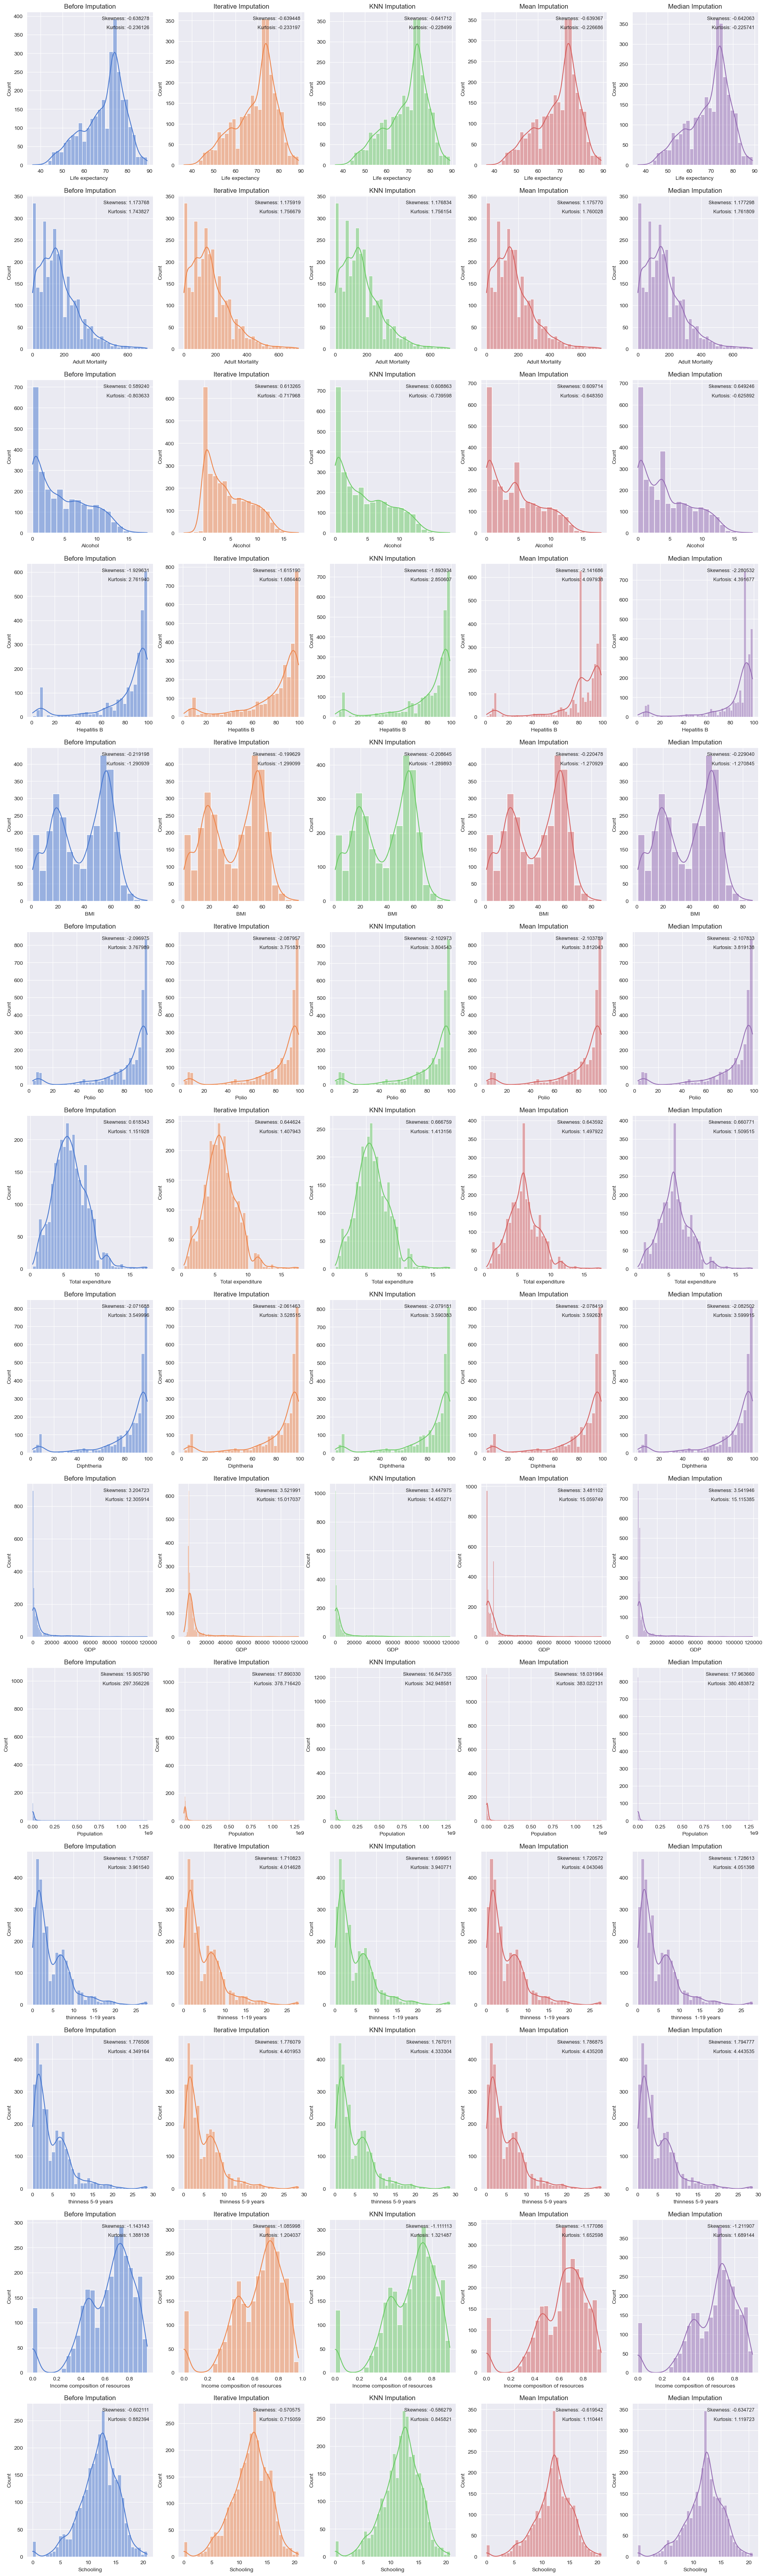

In [149]:
draw_histplot()

In [150]:
corr_matrix_knn = life_imp_knn.corr()
corr_matrix_iter = life_imp_iter.corr()

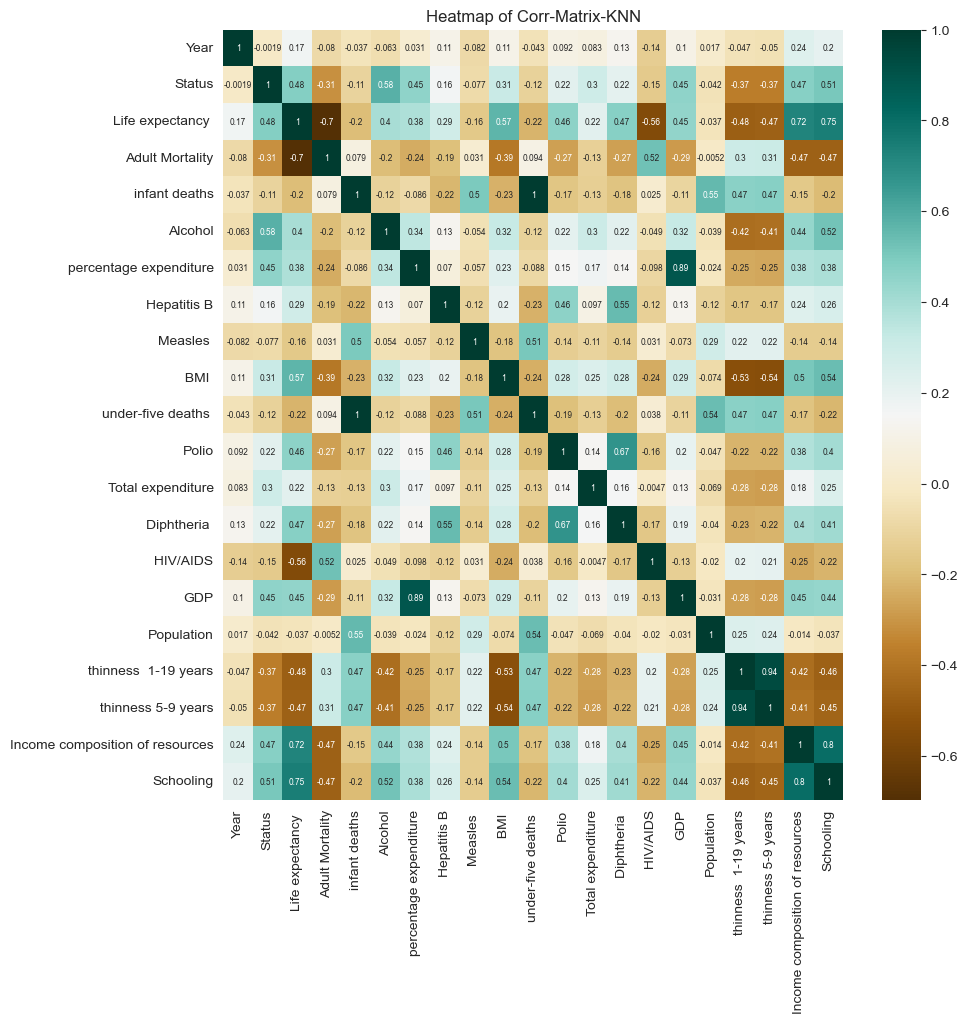

In [151]:
f, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr_matrix_knn, annot=True, cmap="BrBG", annot_kws={"size": 6})
ax.set_title("Heatmap of Corr-Matrix-KNN")
plt.show()
plt.close()

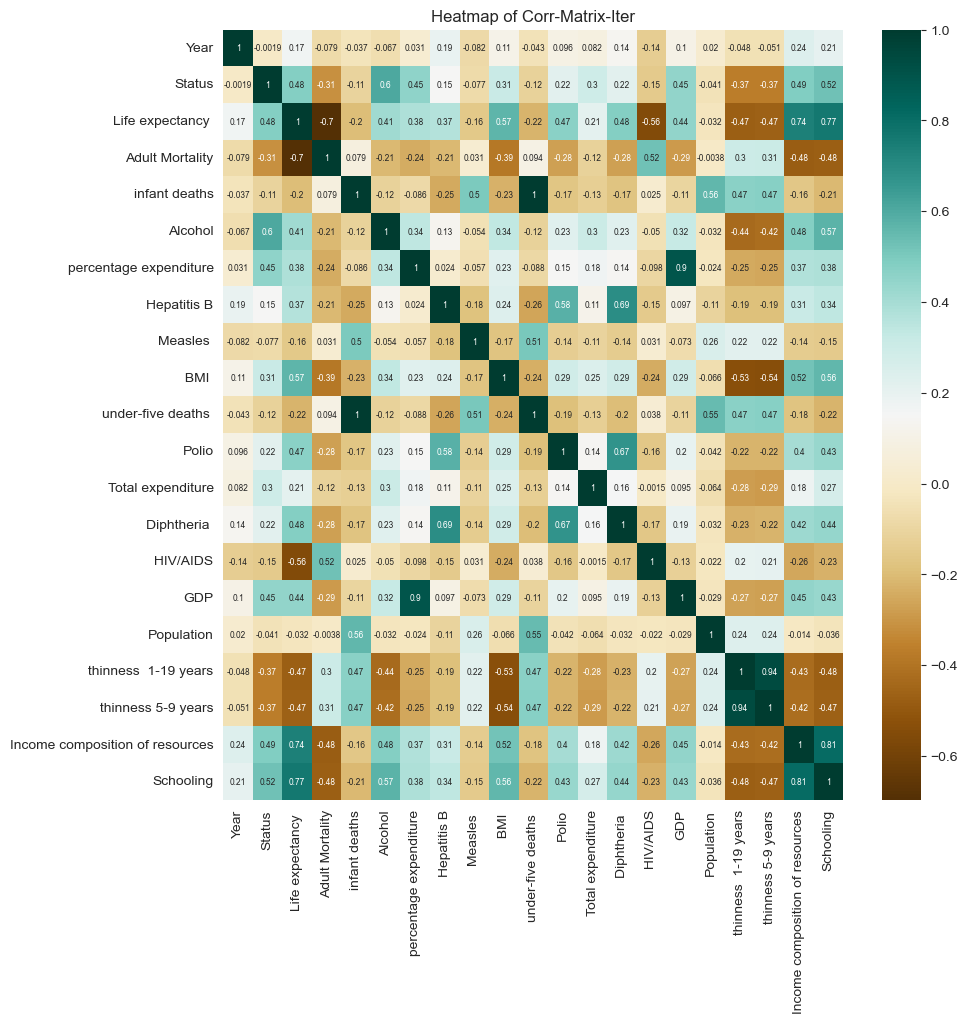

In [152]:
f, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr_matrix_iter, annot=True, cmap="BrBG", annot_kws={"size": 6})
ax.set_title("Heatmap of Corr-Matrix-Iter")
plt.show()
plt.close()

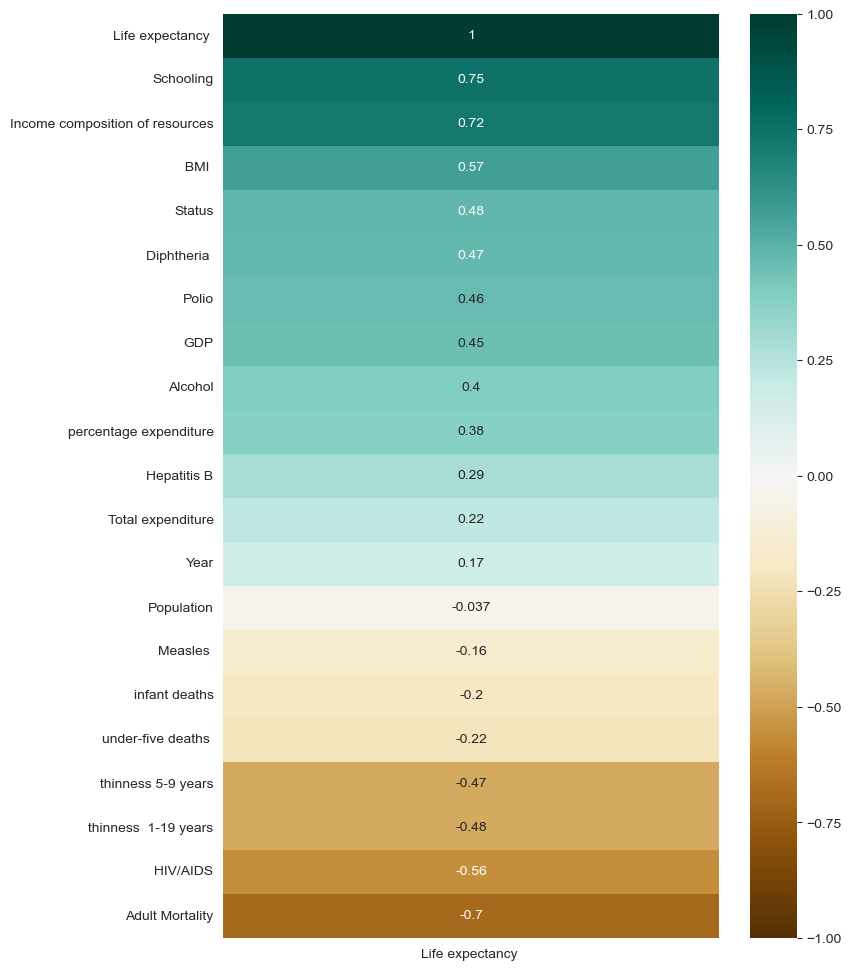

In [153]:
f, ax = plt.subplots(figsize=(8,12))

ax = sns.heatmap(corr_matrix_knn[["Life expectancy "]].sort_values(by="Life expectancy ", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
plt.show()
plt.close()

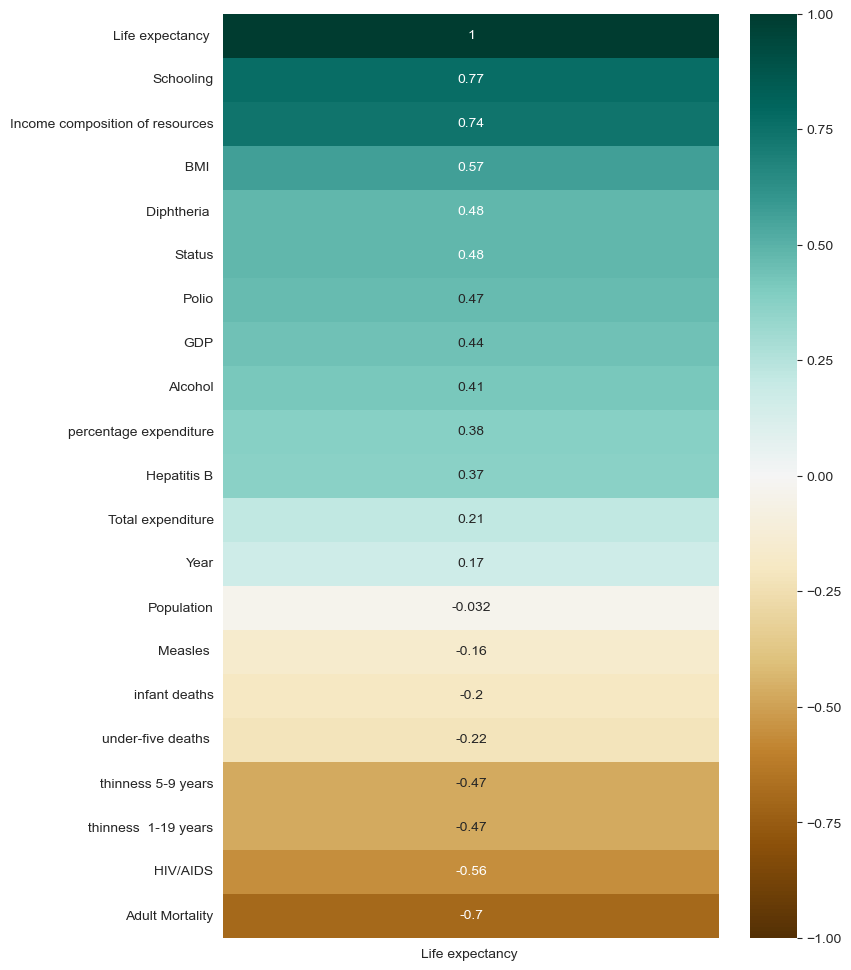

In [154]:
f, ax = plt.subplots(figsize=(8,12))

ax = sns.heatmap(corr_matrix_iter[["Life expectancy "]].sort_values(by="Life expectancy ", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
plt.show()
plt.close()

**X contains all the dependent features that will be used to train the ML model.**
1. We exlud `Life Expectancy` from X because it is our target variable
2. According to our heatmap we can drop `Populations`, `Year` and `Measles`

**Y contains our target variable `Life Expectancy`**


In [155]:
X = life_imp_iter.drop(columns= ["Population", "Life expectancy ", "Year", "Measles "])

Y = life_imp_iter["Life expectancy "].values

In [156]:
print(f"There are currently {X.shape} rows and columns in X \n {Y.shape} rows and columns in Y respectively")

There are currently (2938, 17) rows and columns in X 
 (2938,) rows and columns in Y respectively


## Training and testing a machine learning pipeline

Support Vector Regression (SVR) is a type of regression analysis algorithm used when the relationship between the independent and dependent variables is non-linear. SVR can handle high-dimensional data effectively, making it a good choice for regression problems involving large numbers of features. When using SVR, multicollinearity is not an issue making it easier to work with in this case. Also, it can handle high dimensional data better than other algorithms like Linear Regression. We did not use Decision Tree because they tend to overfit with small datasets like ours. We can avoid that by ensemble methods like Random Forest but still decided to go with SVR.

Standardization is a preprocessing step that transforms variables to have a mean of 0 and a standard deviation of 1. It is important to scale the features so that each feature contributes equally to the distance computation. Standardization is a recommended preprocessing step for our SVR algorithm and can lead to improved results

Our variables are skewed, so transforming them can help make them more normally distributed, improve the performance and interpretabiliy of the model


In [157]:
# Z-Transformation
X = StandardScaler().fit_transform(X)

In [158]:
# Split data into training and test sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

C, gamma, and kernel are hyperparameters of the Support Vector Regression (SVR) model used in machine learning for regression tasks. Here is a brief description of each hyperparameter:

C: The regularization strength of the model. It controls the trade-off between the model's complexity and fitting to the training data. A smaller value of C leads to a simpler model with higher regularization, while a larger value of C leads to a more complex model with less regularization. The default value of C is 1.0.

gamma: The kernel coefficient for rbf, poly, and sigmoid. It defines the influence of each individual training example on the model. A smaller value of gamma leads to each example having a far-reaching influence, while a larger value of gamma leads to only the closest neighbors having a strong influence. The default value of gamma is scale, which is 1 / (n_features * X.var()).

kernel: The kernel function used to compute the similarity between the training examples. The three most common kernel functions are linear, rbf, and poly. The linear kernel is used for linear regression, while the rbf and poly kernels are used for non-linear regression. The default value of kernel is rbf.

Fine-tuning these hyperparameters can strongly influence the performance of the model. Too complex a model can lead to overfitting, while too simple a model can lead to underfitting. Using hyperparameter tuning techniques such as the GridSearchCV function can help to find the best hyperparameter values to create the best model.

In [159]:
svr = SVR()

# Setting the values of our hyperparameters
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear', 'rbf']}

grid_search = GridSearchCV(svr, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [160]:
Y_pred = grid_search.predict(X_test)

In [161]:
print("Train Accuracy: ", grid_search.score(X_train, Y_train))
print("Test Accuracy: ", grid_search.score(X_test, Y_test))

Train Accuracy:  0.9819617374069238
Test Accuracy:  0.9474651241876377


The **mean_squared_error** function calculates the average of the squared differences between the actual and predicted target values. The higher the MSE value, the worse the model's performance.

The **mean_absolute_error** function calculates the average of the absolute differences between the actual and predicted target values. The lower the MAE value, the better the model's performance.

In [162]:
MSE = mean_squared_error(Y_test,Y_pred)
MAE = mean_absolute_error(Y_test, Y_pred)
R2 = r2_score(Y_test, Y_pred)

print("Mean Squarred Error: ", MSE)
print("Mean Absolute Error: ", MAE)
print("R-squared: ", R2)
print("Y_Test Mean: ", Y_test.mean())
print("Y_Pred Mean: ", Y_pred.mean())

Mean Squarred Error:  4.571549578988737
Mean Absolute Error:  1.299409226238196
R-squared:  0.9474651241876377
Y_Test Mean:  68.99772492497519
Y_Pred Mean:  68.99319244232562


The mean squared error (MSE) of your model is 4.57, which indicates that the model is making relatively small errors in its predictions. The mean absolute error (MAE) of the model is 1.3, which is the average magnitude of the errors in the model's predictions.

The R-squared value of the model is 0.95, which indicates that the model explains 95% of the variance in the target variable. This is a good value, and suggests that the model is performing well.

The mean of the target variable Y_Test is 69, and the mean of the predicted values Y_Pred is also close to 69. This indicates that the model is predicting values that are close to the actual values, on average.

In [163]:
#Estimating the Bias and Variance using bias_variance_decomp() from mlxtend.evaluate library

mse, bias, var = bias_variance_decomp(svr, X_train, Y_train, X_test, Y_test, loss="mse")

print("MSE: %.3f" % mse)
print("Bias: %.3f" % bias)
print("Variance: %.3f" % var)

MSE: 9.017
Bias: 8.739
Variance: 0.278


The output of bias_variance_decomp() shows that the mean squared error (MSE) of your model is 9.063, which is higher than the MSE obtained using mean_squared_error() previously. This is because bias_variance_decomp() considers the decomposition of the error into bias, variance, and irreducible error.

The bias of the model is 8.785, which indicates that the model is underfitting the data. This means that the model is not complex enough to capture the underlying patterns in the data.

The variance of the model is 0.278, which is relatively low compared to the bias. This suggests that the model is not overfitting the data.

In summary, the model is suffering from underfitting and requires more complex features or a more flexible model to capture the underlying patterns in the data.

## Support Vector Regression (SVR) has the following pros and cons:

**Pros:**

- Robustness: SVR performs well on datasets with high levels of noise and outliers.

- Flexibility: SVR can be used with different kernel functions, such as linear, polynomial, and radial basis function (RBF), which allows it to model complex nonlinear relationships.

- Memory efficiency: SVR only needs to store a subset of the training examples, called support vectors, which can lead to memory efficiency when working with large datasets.

**Cons:**

- Slow training time: The training time of SVR can be slow, especially when using large datasets or complex kernels.

- High sensitivity to hyperparameters: The performance of SVR is sensitive to the choice of hyperparameters, such as the kernel function and regularization parameter. Tuning these hyperparameters can be a time-consuming process.

- Not suitable for online learning: SVR requires all the training data to be present at the time of training, which makes it less suitable for online learning scenarios where new data points are constantly being added.

- Interpretability: The resulting model from SVR is not very interpretable, meaning that it can be difficult to understand how the model is making its predictions.